# Adaption of CCN simulation

## Change-log
| Function | Detail | Date |
| ---- | ------------ | - |
| init_weights | sample them from prefect mean | 14.11 |
|  |  |  |
|  |  |  |

In [3]:
import argparse
import sys
import os
import json
import numpy as np

from ccn_envs import create_env
from datetime import datetime

from scipy.special import softmax
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

## Helpers

In [4]:
def loss_fn(R_hat, R):
    """
    Mean Squared error
    R: Expected Rewards of all Agents
    S: Label
    """
    return 1/(len(R)) * np.sum(((R - R_hat) ** 2), axis=1)


def loss_gradients(R_hat, F, R):
    """
    Derivative of Mean Squared Error
    OMEGA: All Weights
    F: Feature matrix of all agents
    S: Label
    """
    dL = - 1 / (len(R)) * (R - (R_hat)) @ (2 * F)
    return dL

def clip_steps(position, grid_size):
    return np.clip(position, 0, grid_size - 1)

def draw_step(positions, prob_dist, rng):
    """@:return: (array [x1, x2]) the position"""
    return rng.choice(positions, p=prob_dist)



In [5]:
weight_cols = ["social imitation $\gamma$", "random jumps $\eta$", "noise $\\nu$", "privilege $\\rho$"]

In [14]:
rng = np.random.default_rng(0)

## Policy functions 

In [6]:
# Starting positions
def initialize_starting_position(env, n_agents, rho):
    """Init starting position based on last noise feature interpreted as quantile of fitness landscape"""
    quantiles = np.quantile(env, rho)
    all_positions = np.empty((n_agents, 2), dtype=int)
    for i, q in enumerate(quantiles):
        q_pos = np.where((np.round(q, 2) == np.round(env, 2)))
        q_pos_index = rng.integers(0, len(q_pos[0]))
        all_positions[i] = [q_pos[0][q_pos_index], q_pos[1][q_pos_index]]
    S = env[all_positions[:, 0], all_positions[:, 1]]
    return all_positions, S

def initialize_starting_position_fair(env, n_agents):
    """Init starting position based on last noise feature interpreted as quantile of fitness landscape"""
    all_positions = np.empty((n_agents, 2), dtype=int)
    quantile = np.quantile(env, 0.2)

    q_pos = np.where((np.round(quantile, 2) == np.round(env, 2)))
    for i in range(n_agents):
        q_pos_index = rng.integers(0, len(q_pos[0]))
        all_positions[i] = [q_pos[0][q_pos_index], q_pos[1][q_pos_index]]
    S = env[all_positions[:, 0], all_positions[:, 1]]
    return all_positions, S


def initialize_starting_position_random(env, n_agents):
    """Init starting position based on last noise feature interpreted as quantile of fitness landscape"""
    all_positions = rng.integers(0,1000, size=(n_agents, 2))
    S = env[all_positions[:, 0], all_positions[:, 1]]
    return all_positions, S


In [147]:
def local_search(env: np.array, agent_value, eta: float, position: np.array, steps, grid_size, tau, rng):
    """Stochastic Hill climbing OR random step (only if better)"""
    if eta >= rng.uniform(0, 1):
        rand_pos = rng.integers(0, grid_size, 2)
        rand_value = env[rand_pos[0]][rand_pos[1]]
        if rand_value > agent_value:
            return rand_pos.reshape(1, 2), np.array([1.]), False
    neighbour_states = [[clip_steps(position[0]+s[0], grid_size), clip_steps(position[1]+s[1], grid_size)] for s in steps]
    ind_values = np.array([env[p[0]][p[1]] for p in neighbour_states])
    ind_values_pb = softmax((ind_values / tau))
    return np.asarray(neighbour_states), ind_values_pb, agent_value == ind_values.max()


def create_feature_vector(n_agents, noise_features=2, rng=None):
    """Feature matrix F (agents x features): F[agent_i] = [gamma, eta, noise, rho]"""
    # Performance features
    gammas = rng.uniform(0, 1, size=n_agents)
    etas = rng.uniform(0, 1, size=n_agents)

    # Noise features
    f_noise = rng.choice(np.clip(rng.normal([0.3, 0.7], [0.1, 0.1], size=(n_agents, 2)), 0, 1).flat,
                         size=(n_agents, noise_features))

    # Add them together
    F = np.concatenate((np.stack((gammas, etas), axis=1), f_noise), axis=1)
    return F


def create_roleModel_features(n_roleModels, noise_features=2, rng=None):
    """Feature matrix F (n_roleModels x features): F[agent_i] = [gamma, eta, n0, n1, ...]"""
    # Performance features
    gammas = np.clip(rng.normal(0.8, 0.05, size=n_roleModels), 0, 1)
    etas = np.clip(rng.normal(0.8, 0.05, size=n_roleModels), 0, 1)

    # Noise features
    f_noise = np.concatenate((
        rng.choice(np.clip(rng.normal([0.3, 0.7], [0.1, 0.1], size=(n_roleModels, 2)), 0, 1).flat,
                   size=(n_roleModels, noise_features-1)),
        np.clip(
            rng.normal(0.3, 0.1, size=(n_roleModels, 1)),
            0, 1)
    ), axis=1)

    # Add them together
    F = np.concatenate((np.stack((gammas, etas), axis=1), f_noise), axis=1)
    return F


def initialize_role_models(env, n_roleModels):
    """Init less privileged agents, but explicitly good performance and traits"""
    if env_type == "NK":
        fitness_values = list(env.fitness_dict.values())
        fitness_values = (fitness_values - min(fitness_values)) 
        fitness_values /= max(fitness_values)
        max_values = np.sort(fitness_values)[-100:]
        S = rng.choice(max_values, size=n_roleModels)
        # quantile = np.quantile(fitness_values, 0.99)
        # high_pos = np.where((np.round(quantile, 3) < np.round(fitness_values, 3)))[0]
        # indexes = rng.choice(high_pos, size=n_roleModels)
        # S = fitness_values[indexes]
        # states = np.array([env.get_fitness(np.array(list(f'{i:020b}')).astype(int)) for i in index])
        return S
        
    quantile = np.quantile(env, 0.9)
    high_pos = np.where((np.round(quantile, 3) < np.round(env, 3)))
    start_pos_index = rng.integers(0, len(high_pos[0]), n_roleModels)
    all_positions = np.stack((high_pos[0][start_pos_index], high_pos[1][start_pos_index]), axis=1)
    S = env[all_positions[:, 0], all_positions[:, 1]]
    return S


def intervention_gradient(W, F_rm, R_rm, b, n_roleModels, chosen_agents):
    """Calculate gradients for agents impacted by a mentor"""
    roleModels = rng.integers(n_roleModels, size=len(chosen_agents))
    R_hat_rm = W[chosen_agents] @ F_rm[roleModels].T + b
    W_grad = np.zeros_like(W)
    if len(R_hat_rm) > 0:
        grad_rm = loss_gradients(R_hat_rm, F_rm[roleModels], R_rm[roleModels])
        W_grad[chosen_agents] = grad_rm
    return W_grad


def run_intervention(n_roleModels, sigma, F, W, F_rm, R_rm, b, rng):
    """Run intervention which mentor impacts which less privileged agent"""
    chosen_agents = np.where(F[:, -1] < 0.5)[0]
    drawn_sigma = rng.random(size=len(chosen_agents))
    chosen_agents = chosen_agents[np.where(drawn_sigma <= sigma)[0]]
    return intervention_gradient(W, F_rm, R_rm, b, n_roleModels, chosen_agents)


def scale_eta(eta):
    """For eta in [0,1]"""
    return 0.1 * eta


def scale_gamma(gamma):
    """For gamma in [0,1]"""
    return 0.1 * gamma


## NK function

**Adjustements for nk**
- Try with random exploration and K=1
- Pertubation mechansims: To escape local optima (f.e. random jumps):
    - random jumps are bad: Make them better by sampling specifically good positions
    - give them more options to choose from for one iteration (like steepest ascent)
    - Make a few following steps

In [8]:
from ccn_envs import create_env, NK_landscape_loaded

In [15]:
file = "N20K5_5.pkl"

with open(file, 'rb') as f:
    landscapes = pickle.load(f)

n_landscapes = int(str(file.split("_")[1]).split(".")[0])
N, K = str(file.split("_")[0])[1:].split("K")
N, K = int(N), int(K)

env_type = "NK"


for i in range(n_landscapes):
    keys = landscapes[i].keys()
    values = np.array(list(landscapes[i].values()))
    values = values **6
    landscapes[i] = dict(zip(keys, values))


env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])
tau = 0.05

### Initializing on nk landscape

In [16]:
def initialize_starting_position_NK_random(env, n_agents):
    states = np.round(rng.random((n_agents, env.N))).astype(int)
    scores = np.array([env.get_fitness(state) for state in states])
    return states, scores

def initialize_starting_position_NK_fair(env, n_agents):
    fitness_values = list(env.fitness_dict.values())
    fitness_values = (fitness_values - min(fitness_values)) 
    fitness_values /= max(fitness_values)
    quantile = np.quantile(fitness_values, 0.2)
    low_pos = np.where((np.round(quantile, 2) == np.round(fitness_values, 2)))[0]
    index = rng.choice(low_pos, size=n_agents).astype(int)
    S = fitness_values[index]
    states = np.array([np.array(list(f'{i:020b}')).astype(int) for i in index])
    return states, S

def initialize_starting_position_NK(env, n_agents, rho):
    fitness_values = list(env.fitness_dict.values())
    fitness_values = (fitness_values - min(fitness_values)) 
    fitness_values /= max(fitness_values)
    quantile = np.quantile(fitness_values, rho)
    S = np.zeros(n_agents)
    states = np.empty((n_agents, N)).astype(int)
    for _, q in enumerate(quantile):
        low_pos = np.where((np.round(q, 2) == np.round(fitness_values, 2)))[0]
        if len(low_pos) == 0:
            while len(low_pos) == 0:
                low_pos = np.where((np.round(q, 2) == np.round(fitness_values, 2)))[0]
        index = rng.choice(low_pos).astype(int)
        S[_] = fitness_values[index]
        states[_] = np.array(list(f'{index:020b}')).astype(int)
    return states, S

In [17]:
""" # Plot the distribution of a starting position
n_agents = 300

rho = rng.random(n_agents)
_, scores =  initialize_starting_position_NK(env, n_agents, rho)
plt.scatter(rho, scores)
print(pearsonr(rho, scores))
"""

' # Plot the distribution of a starting position\nn_agents = 300\n\nrho = rng.random(n_agents)\n_, scores =  initialize_starting_position_NK(env, n_agents, rho)\nplt.scatter(rho, scores)\nprint(pearsonr(rho, scores))\n'

### Eta attribute for NK - SHC  

In [132]:
def bit_switch(state, digit):
    if state[digit] == 1:
        state[digit] = 0
    else:
        state[digit] = 1
    return state
    
def local_search_nk_jump(env, state, score, eta):
    if eta >= rng.uniform(0, 1):
        random_states = [np.round(rng.random(env.N)).astype(int) for _ in range(5)]
        random_scores = np.array([env.get_fitness(random_state) for random_state in random_states])
        if max(random_scores) >= score:
            return np.array([random_states[np.argmax(random_scores)]]), np.array([1.])
    
    digits = rng.choice(20, size=(3), replace=False)
    neigh_states = np.zeros((len(digits) +1,N)).astype(int)
    neigh_states[0] = state 
    neigh_states[1:] = np.array([bit_switch(state.copy(), digit) for digit in digits])
    neigh_scores = np.array([env.get_fitness(ns) for ns in neigh_states])
    neigh_pb = softmax((neigh_scores / tau))
    return neigh_states, neigh_pb

def local_search_nk(env, state, score, eta):
    digits = rng.choice(20, size=(eta), replace=False)
    neigh_states = np.zeros((len(digits) +1,N)).astype(int)
    neigh_states[0] = state 
    neigh_states[1:] = np.array([bit_switch(state.copy(), digit) for digit in digits])
    neigh_scores = np.array([env.get_fitness(ns) for ns in neigh_states])
    neigh_pb = softmax((neigh_scores / tau))
    return neigh_states, neigh_pb

def local_search_nk_1n(env, state, score, eta):
    eta_n = 3 if eta >= rng.uniform(0, 1) else 1
        
    digits = rng.choice(20, size=(eta_n), replace=False)
    neigh_states = np.zeros((len(digits) +1,N)).astype(int)
    neigh_states[0] = state 
    neigh_states[1:] = np.array([bit_switch(state.copy(), digit) for digit in digits])
    neigh_scores = np.array([env.get_fitness(ns) for ns in neigh_states])
    neigh_pb = softmax((neigh_scores / tau))
        
        
    return neigh_states, neigh_pb
   

In [115]:
def SHC(env, iterations = 150, eta=0.05):
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_fitness(state)
    
    all_scores = np.zeros(iterations+1)
    all_scores[0] = score
    for i in range(iterations):
        neigh_states, neigh_pb = local_search_nk_1n(env, state, score, eta)
        state = draw_step(neigh_states, neigh_pb, rng)
        score = env.get_fitness(state)
        all_scores[i+1] = score
    
    return all_scores, state


Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Mean score of last states 0.62828


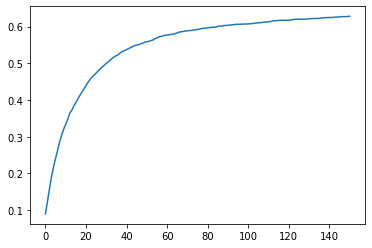

In [122]:
iterations    = 150
score_counter = np.zeros(iterations+1)
n_trials = 500

eta_corr = np.zeros((n_trials, 2))
check_states = []
for _ in range(n_trials):
    eta = rng.random()
    eta_s = eta**2
    # eta_s = int(np.round(np.clip(eta*3, 1, 20)))
    
    all_scores, state = SHC(env, iterations, eta_s)
    score_counter += all_scores
    eta_corr[_] = [all_scores.mean(), eta]
    
    check_states.append(env.get_fitness(state))
    
    if (_+1) % 100 == 0:
        print("Iteration:", _+1)

if n_trials ==1:
    print(eta, eta_s)
print("Mean score of last states", np.array(check_states).mean())
score_counter /= n_trials
plt.plot(score_counter)

(0.26833256264828975, 1.0790727810913094e-09)


Text(0, 0.5, 'Mean score')

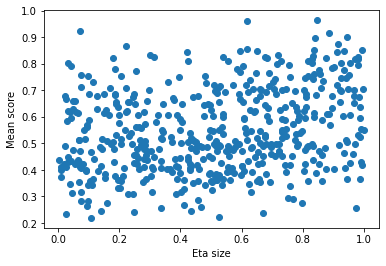

In [123]:
print(pearsonr(eta_corr[:,0], eta_corr[:,1]))
plt.scatter(eta_corr[:,1], eta_corr[:,0])
plt.xlabel("Eta size")
plt.ylabel("Mean score")

## Simulation

### Ideas for adjustement
* Always sample one agent to trust and only adjust social values for this agent (follow this agent)
    * Think of social imitation every iteration, just don't do it every time
    * Privilege would not break as easily, as privileged agents are chosen more often
* Enhance SHC by not taking a single solution but considering k solutions + softmax
* All NK Landscapes seem disributed equally independent of K; Are the values scaled correctly?

In [192]:
def run_simulation(grid_size, n_agents, intervention, F, lr, max_iter, env, all_steps,
                   R_scale, beta, tau, intervention_start, sigma, rng):
    """Implements one full simulation run"""

    gammas = scale_gamma(F[:, 0])
    if env_type != "NK":
        etas = scale_eta(F[:, 1])
    else:
        etas = np.clip(F[:, 1]*3, 1, 20).astype(int)
        # etas = F[:, 1]**2
    rho = F[:, -1]

    # Init agents based on privilege
    if env_type != "NK":
        all_positions, S = initialize_starting_position(env, n_agents, rho)
        # all_positions, S = initialize_starting_position_random(env, n_agents)
    else:
        all_positions, S = initialize_starting_position_NK(env, n_agents, rho)
        # all_positions, S = initialize_starting_position_NK_fair(env, n_agents)
        # all_positions, S = initialize_starting_position_NK_random(env, n_agents)

        
    # Trait Learning
    W = rng.normal((max(S)-min(S))*0.25, 0.1, (n_agents, 4))  # *F.mean()/4
    # W = rng.normal(S.mean()*0.25, 0.1, (n_agents, 4))  # *F.mean()/4
    
    A = W @ F.T

    # Simulation tracking variables
    intermediate_positions = np.zeros_like(all_positions)
    intermediate_S = np.zeros_like(S)
    S_history = np.empty((max_iter, n_agents))
    S_history[0] = S
    R = S

    W_history = np.empty((max_iter, F.shape[1]))
    W_history[0] = W.mean(axis=0)

    iteration = 1
    while iteration < max_iter:

        # 0. Calculate social values
        Y = softmax((A/A.sum(axis=1)) / tau, axis=1)

        for agent_index in range(n_agents):
            # 1. Social learning
            if gammas[agent_index] >= rng.random():
                next_position = draw_step(all_positions, Y[agent_index], rng)
                if env_type != "NK":
                    next_S = env[next_position[0]][next_position[1]]
                else:
                    next_S = env.get_fitness(next_position)
            
            else:
                # 2. Local search
                if env_type != "NK":
                    positions, p_dist, use_social = local_search(env, S[agent_index], etas[agent_index],
                                                             all_positions[agent_index], all_steps,
                                                             grid_size, tau, rng)
                    next_position = draw_step(positions, p_dist, rng)
                    next_S = env[next_position[0]][next_position[1]]
                else:
                    positions, p_dist = local_search_nk(env, all_positions[agent_index], S[agent_index],
                                                              etas[agent_index])
                    next_position = draw_step(positions, p_dist, rng)
                    next_S = env.get_fitness(next_position)

            # 3. safe values to update after all agents are through
            intermediate_positions[agent_index] = next_position
            intermediate_S[agent_index] = next_S
            
        # 4. Optimize W
        R_decay = R_scale[-iteration:] / R_scale[-iteration:].sum()
        R = R_decay @ S_history[:iteration]
        
        b = R.min()
        R_hat = W @ F.T + b
        grad = loss_gradients(R_hat, F, R)  # TODO: Check if gradients are for correct objective R_hat = W*F + b 
        W -= (lr * grad.T).T

        # 4.1 Gradient of intervention
        if intervention is True:
            # if (intervention_start < iteration):
            if (intervention_start < iteration <= intervention_start+5):
                grad_rm = run_intervention(n_roleModels, sigma, F, W, F_rm, R_rm, b, rng)
                W -= lr * grad_rm

        W_history[iteration] = W.mean(axis=0)
        A += beta * (W @ F.T - A)
        
        # 5. All agents walk at the same time
        S = intermediate_S
        all_positions = intermediate_positions
        S_history[iteration] = S

        iteration += 1

    loss = loss_fn(R_hat, R)
    return S_history, W, A, loss, W_history



**Changes todo**:
* Weight init
* Gradient size


## Run simulation

In [203]:
# Prepare setup of environment
file = "N20K5_5.pkl"  # K=1,2,5,10 for N=20

with open(file, 'rb') as f:
    landscapes = pickle.load(f)

n_landscapes = int(str(file.split("_")[1]).split(".")[0])
N, K = str(file.split("_")[0])[1:].split("K")
N, K = int(N), int(K)

for i in range(n_landscapes):
    keys = landscapes[i].keys()
    values = np.array(list(landscapes[i].values()))
    values = values ** 6
    landscapes[i] = dict(zip(keys, values))

env_names = ["MasonWatts", "Ackley", "DropWave"]


In [204]:
def run(total_simulations, intervention, env_type):
    sys.stdout.write(f'\nSimulation is starting: Environment: {env_type} Intervention: {intervention} \n')
    rng = np.random.default_rng(seed)
    # Create environment
    if env_type != "NK":
        envs = [create_env(env_n, grid_size)[0] for env_n in env_names]
    else:
        envs = landscapes
    
    # Setup for intevention
    if intervention is True:
        F_rm = create_roleModel_features(n_roleModels, noise_features, rng)
        if env_type == "NK":
            env = NK_landscape_loaded(N, K, envs[rng.integers(0, n_landscapes)])
            R_rm = initialize_role_models(env, n_roleModels)


    # Result saving
    all_results = np.empty((total_simulations * n_agents, 13))  # Second param: How many vars to track
    W_results = np.zeros((max_iterations, 4))

    S_results = np.zeros(max_iterations)


    # Start running simulations
    sys.stdout.write(f"\nIn total {total_simulations} simulations")
    for _ in range(total_simulations):
        
        # Choose landscape
        if env_type == "NK":
            env = NK_landscape_loaded(N, K, envs[rng.integers(0, n_landscapes)])
        else:
            env = envs[rng.integers(0, len(envs))]
            if intervention is True:
                R_rm = initialize_role_models(env, n_roleModels)

        # Create traits
        F = create_feature_vector(n_agents=n_agents, noise_features=noise_features, rng=rng)
        
        S_history, W, A, loss, W_history = run_simulation(grid_size=grid_size, n_agents=n_agents, intervention=intervention,
                                                          F=F, lr=lr, max_iter=max_iterations,
                                                          env=env, all_steps=all_steps, R_scale=R_scale,
                                                          beta=beta, tau=tau, intervention_start=intervention_start,
                                                          sigma=sigma, rng=rng)
        
        run_results = np.concatenate((F,
                                      W,
                                      S_history.max(axis=0).reshape(n_agents, 1),
                                      S_history.mean(axis=0).reshape(n_agents, 1),
                                      S_history[0].reshape(n_agents, 1),
                                      loss.reshape(n_agents, 1),
                                      A.mean(axis=0).reshape(n_agents, 1),
                                      ), axis=1)

        all_results[_*n_agents: _*n_agents+n_agents] = run_results
        W_results += W_history
        S_results += S_history.mean(axis=1)

        if (_+1) % 100 == 0:
            sys.stdout.write(f"\n Simulation: {_+1}")

    W_results /= total_simulations
    S_results /= total_simulations
    sys.stdout.write(f"\nFinished successfully \n")
    return W_results, S_results, all_results

In [210]:
# Simulation parameter
seed = 0

grid_size = 1000
total_simulations = 2000
max_iterations = 150
n_agents = 7


all_steps = np.array([[i, j] for i in np.arange(-1, 2) for j in np.arange(-1, 2)])

lr = 0.1
noise_features = 2  # Number of noise features (keep to 2)
beta = 0.5  # Learning rate for social influence matrix A
tau = 0.01  # Exploitation for social and individual optimization


intervention = False
n_roleModels = 2
sigma = 0.2  # Probability for mentor connections during continuous intervention
intervention_start = 50

# Label scaling
lambda_scale = 0.9  # Label decay
R_scale = lambda_scale ** np.arange(max_iterations - 1, -1, -1)


env_type = "NK" # 2D


In [ ]:
# intervention = True
# W_results_int, S_results_int, all_results_int = run(total_simulations, intervention, env_type)


intervention = False
W_results, S_results, all_results = run(total_simulations, intervention, env_type)


Simulation is starting: Environment: NK Intervention: False 

In total 2000 simulations

In [ ]:
with open('intervention.npy', 'wb') as f:
    np.save(f, W_results_int)
    np.save(f, S_results_int)
    np.save(f, all_results_int)

with open('no_intervention.npy', 'wb') as f:
    np.save(f, W_results)
    np.save(f, S_results)
    np.save(f, all_results)
    
"""
with open('test.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
"""

In [214]:
all_results.shape

(4900, 13)

In [ ]:
colors = ["royalblue", "gold", "darkorchid", "forestgreen"]

fig, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].plot(S_results_int, color="blue")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Mean Score")
axs[0].set_title("Performance")


W_norm_int = W_results_int/ W_results_int.sum(axis=1).reshape(-1,1)
for (i, weight_name), color in zip(enumerate(weight_cols), colors):
    axs[1].plot(W_norm_int[:,i], label=weight_name, color=color)
axs[1].set_title("Relative Weights")
axs[1].axvline(x=intervention_start, color="black", linestyle='dashed')


axs[2].set_title("Absolute Weights")
for (i, weight_name), color in zip(enumerate(weight_cols), colors):
    axs[2].plot(W_results_int[:,i], label=weight_name, color=color)
axs[2].axvline(x=intervention_start, color="black", linestyle='dashed')
axs[2].legend()


# Add usual weights
# fig, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].plot(S_results, linestyle="dashed", color="blue")

W_norm = W_results/ W_results.sum(axis=1).reshape(-1,1)
for (i, weight_name), color in zip(enumerate(weight_cols), colors):
    axs[1].plot(W_norm[:,i], label=weight_name, linestyle="dashed", color=color)

for (i, weight_name), color in zip(enumerate(weight_cols), colors):
    axs[2].plot(W_results[:,i], label=weight_name, linestyle="dashed", color=color)


In [184]:
# Max, Mean, Start Value
print("Max, Mean, Start Value")
print(all_results[:,8:11].mean(axis=0))
print(all_results_int[:,8:11].mean(axis=0))


array([0.63225714, 0.49804733, 0.07789442])

In [186]:
print("Corr of Feature and mean agent score")
print("Normal      ", [pearsonr(all_results[:,i], all_results[:,9]) for i in range(4)])
print("Intervention", [pearsonr(all_results[:,i], all_results[:,9]) for i in range(4)])

[(0.11348519628214362, 1.845112728980899e-07),
 (0.11697334711290865, 7.630107647024503e-08),
 (-0.005297813830679276, 0.8082893410597719),
 (0.03924922849053694, 0.07213778082302533)]

(0.813213000464743, 0.0)


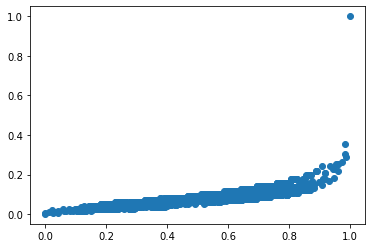

In [173]:
# Correlation: start value - privilege  
print(pearsonr(all_results[:,3], all_results[:,10]))
plt.scatter(all_results[:,3], all_results[:,10])

### Explore 2D landscapes distribution

In [483]:
envs = ["MasonWatts", "Ackley", "DropWave"]

MW, _ = create_env("MasonWatts", 1000)
ACK, _ = create_env("Ackley", 1000)
DW, _ = create_env("DropWave", 1000)

(array([532856., 264240.,  97456.,  42480.,  26968.,  12656.,  10556.,
          8516.,   2072.,   2200.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

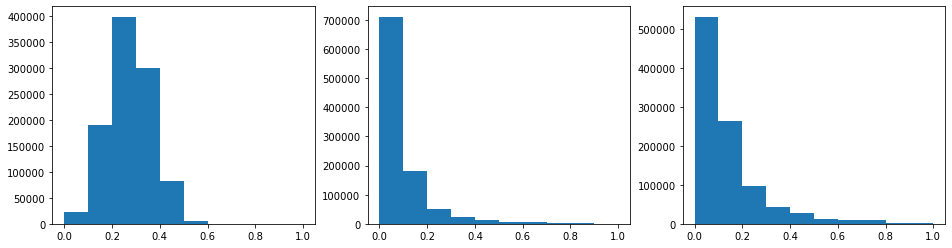

In [502]:
fig, axs = plt.subplots(1,3, figsize=(16,4))

axs[0].hist((MW).flat)
axs[1].hist(ACK.flat)
axs[2].hist(DW.flat)

In [506]:
MW.mean(), ACK.mean(), DW.mean()

(0.27424043006953464, 0.09638651913948465, 0.13256320525959128)

In [505]:
MW.std(), ACK.std(), DW.std()

(0.09008276409252265, 0.10745094384746584, 0.14906804281736985)

### Check nk landscpaes

In [494]:
def norm_nk(env):
    nk_values = np.array(list(env.values()))**6
    nk_values = (nk_values - min(nk_values)) / max(nk_values - min(nk_values))
    return nk_values

(array([7.78827e+05, 2.24347e+05, 3.57530e+04, 7.70900e+03, 1.49000e+03,
        3.24000e+02, 9.40000e+01, 2.40000e+01, 6.00000e+00, 2.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

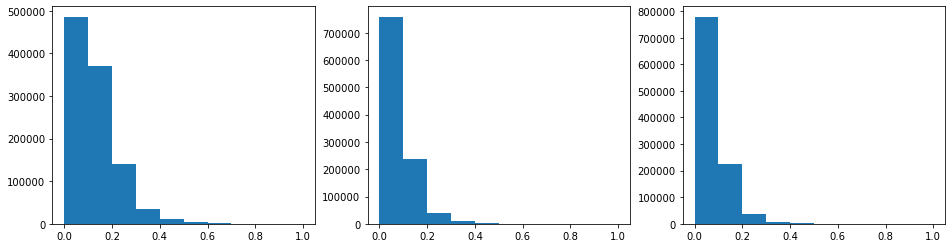

In [495]:
file1 = "N20K1_5.pkl"
file5 = "N20K5_5.pkl"
file10 = "N20K10_5.pkl"

with open(file1, 'rb') as f:
    landscapes = pickle.load(f)
nk_values1 = norm_nk(landscapes[0])
with open(file5, 'rb') as f:
    landscapes = pickle.load(f)
nk_values5 = norm_nk(landscapes[0])
with open(file10, 'rb') as f:
    landscapes = pickle.load(f)
nk_values10 = norm_nk(landscapes[0])

fig, axs = plt.subplots(1,3, figsize=(16,4))

axs[0].hist(nk_values1)
axs[1].hist(nk_values5)
axs[2].hist(nk_values10)

In [500]:
nk_values1.mean(), nk_values5.mean(), nk_values10.mean()

(0.12657871622234346, 0.07980918268476872, 0.07617407102498946)

In [501]:
nk_values1.std(), nk_values5.std(), nk_values10.std()

(0.08789977016736514, 0.062203533667093996, 0.060569186697489466)

#### Check modality

In [14]:
from itertools import product

In [35]:
rng = np.random.default_rng(0)
tau=0.01


In [19]:
def check_modality(env):
    states = np.array(list(product([0,1], repeat=env.N)))
    peak_counter = 0
    peak_states = []
    for state in states:
        score = env.get_fitness(state)
        
        for index in range(env.N):
            if score < env.get_fitness(bit_switch(state.copy(), index)):
                break
            if index == (env.N - 1):
                peak_counter += 1
                peak_states.append(state)
    return peak_counter, peak_states

In [20]:
file = "N20K10_5.pkl"

with open(file, 'rb') as f:
    landscapes = pickle.load(f)
    
N, K = str(file.split("_")[0])[1:].split("K")
N, K = int(N), int(K)

In [21]:
env = NK_landscape_loaded(N, K, landscapes[0])
print(env.N, env.K)

20 10


In [22]:
peak_counter, peak_states = check_modality(env)
peak_counter

13177

In [42]:
peak_state = peak_states[1]
print(env.get_fitness(peak_state))

0.76


In [43]:
for index in range(env.N):
    print(env.get_fitness(bit_switch(peak_state.copy(), index)))

0.72
0.64
0.5
0.45
0.66
0.62
0.57
0.59
0.67
0.48
0.5
0.52
0.66
0.71
0.66
0.52
0.66
0.52
0.6
0.5


In [44]:
def HC_steep(env, iterations = 150, eta=0.05, state=None):
    if state is None:
        state = np.round(rng.random(env.N)).astype(int)
    score = env.get_fitness(state)
    
    all_scores = np.zeros(iterations+1)
    all_scores[0] = score
    for i in range(iterations):
        neigh_states, neigh_pb = local_search_nk(env, state, score, eta)
        state = neigh_states[np.argmax(neigh_pb)]
        score = env.get_fitness(state)
        all_scores[i+1] = score
    
    return all_scores, state
        
    
    

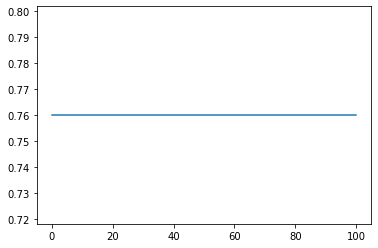

In [45]:
tau=0.01
all_scores, state = HC_steep(env, 100, 3, peak_state)
plt.plot(all_scores)

## Unused code

Policy where agents choose one leader and only learn traits from this leader

In [31]:
def run_simulation_1Agent(grid_size, n_agents, intervention, F, lr, max_iter, env, all_steps,
                   R_scale, beta, tau, intervention_start, sigma, rng):
    """Implements one full simulation run"""

    gammas = scale_gamma(F[:, 0])
    etas = scale_eta(F[:, 1])
    rho = F[:, -1]

    # Init agents based on privilege
    if env_type != "NK":
        all_positions, S = initialize_starting_position(env, n_agents, rho)
        # all_positions, S = initialize_starting_position_random(env, n_agents)
    else:
        all_positions, S = initialize_starting_position_NK(env, n_agents, rho)
        
    # Trait Learning
    W = rng.normal((max(S)-min(S))*0.5, 0.1, (n_agents, 4))
    A = W @ F.T

    # Simulation tracking variables
    intermediate_positions = np.zeros_like(all_positions)
    intermediate_S = np.zeros_like(S)
    S_history = np.empty((max_iter, n_agents))
    S_history[0] = S
    R = S

    W_history = np.empty((max_iter, F.shape[1]))
    W_history[0] = W.mean(axis=0)

    iteration = 1
    while iteration < max_iter:

        # 0. Calculate social values
        b = R.min()
        R_hat = W @ F.T + b
        Y = softmax((A/A.sum(axis=1)) / tau, axis=1)

        leaders = np.zeros(n_agents, dtype=int)
        for agent_index in range(n_agents):
            # 1. Social learning
            leaders[agent_index] = rng.choice(np.arange(n_agents), p=Y[agent_index]).astype(int)
            if gammas[agent_index] >= rng.random():
                next_position = all_positions[leaders[agent_index]]
                if env_type != "NK":
                    next_S = env[next_position[0]][next_position[1]]
                else:
                    next_S = env.get_fitness(next_position)
            else:
                # 2. Local search
                if env_type != "NK":
                    positions, p_dist, use_social = local_search(env, S[agent_index], etas[agent_index],
                                                             all_positions[agent_index], all_steps,
                                                             grid_size, tau, rng)
                
                    next_position = draw_step(positions, p_dist, rng)
                    next_S = env[next_position[0]][next_position[1]]
                else:
                    next_position, next_S = local_search_nk(env, all_positions[agent_index], S[agent_index], etas[agent_index])
            
            # 3. safe values to update after all agents are through
            intermediate_positions[agent_index] = next_position
            intermediate_S[agent_index] = next_S
            
        # 4. Optimize W
        R_decay = R_scale[-iteration:] / R_scale[-iteration:].sum()
        R = R_decay @ S_history[:iteration]        
        grad = loss_gradients(R_hat[leaders], F[leaders], R[leaders])
        W -= (lr * grad.T).T

        # 4.1 Gradient of intervention
        if intervention is True:
            if (intervention_start < iteration):
                grad_rm = run_intervention(n_roleModels, sigma, F, W, F_rm, R_rm, b, rng)
                W -= lr * grad_rm

        W_history[iteration] = W.mean(axis=0)
        A += beta * (W @ F.T - A)
        
        # 5. All agents walk at the same time
        S = intermediate_S
        all_positions = intermediate_positions
        S_history[iteration] = S

        iteration += 1

    loss = loss_fn(R_hat, R)
    return S_history, W, A, loss, W_history


